# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


# Data Understanding

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression


from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression


import pandas as pd
import json
import numpy as np
from numpy import array

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})

import warnings
warnings.filterwarnings("ignore")

custom_colors = ['#006241', '#84233C', '#1E3932', '#9D5116', '#E44C2C']
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [4]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


## A. Portfolio dataset

- There are three different types of offers:
    1. bogo (4 times)
    2. informational (4 times)
    3. discount (2 times)

In [5]:
portfolio['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [6]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


- To deal with the data in an easier way, I will use one-hot encoding for the channels column.

In [7]:
#put the values of channels in a set
channels = set()
for i in portfolio.channels:
    channels.update(set(i))
channels  

{'email', 'mobile', 'social', 'web'}

In [8]:
# split the channel into different attribute
for i in channels:
    portfolio[i] = portfolio.channels.apply(lambda x: i in x).map({True:1, False: 0})

portfolio = portfolio.drop('channels', axis=1)
portfolio

,difficulty,duration,id,offer_type,reward,mobile,social,email,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,0,1,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,0,1,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,0,1,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,0,1,1


In [9]:
portfolio['offer_type'].value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

- As shown below, there are no missing values in the portfolio data and no dublicates.

In [10]:
print("\nCheck for missing values:\n")

for data in [portfolio]:

    print(data.shape)
    print(data.isnull().sum())
    print("\n")

print("\nCheck for duplicate ids:\n")

for data in [portfolio]:

    print(data.shape)
    print(len(data[data.id.duplicated()]))
    print("\n")


Check for missing values:

(10, 9)
difficulty    0
duration      0
id            0
offer_type    0
reward        0
mobile        0
social        0
email         0
web           0
dtype: int64



Check for duplicate ids:

(10, 9)
0




## B. Profile dataset

In [11]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


- We have three values in the gender column:

In [12]:
profile['gender'].unique()

array([None, 'F', 'M', 'O'], dtype=object)

In [13]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


- As shown below, there are more than 2000 missing values in the gender and income columns in the profile data and no dublicates.

In [14]:
print("\nCheck for missing values:\n")

for data in [profile]:

    print(data.shape)
    print(data.isnull().sum())
    print("\n")
    
print("\nCheck for duplicate ids:\n")

for data in [profile]:

    print(data.shape)
    print(len(data[data.id.duplicated()]))
    print("\n")


Check for missing values:

(17000, 5)
age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64



Check for duplicate ids:

(17000, 5)
0




- We can see that when the age value equals 118, the income value and the gender value is null, so we can drop them out of the data.

In [15]:
profile[profile.age > 90][['gender','age','income']].head(10)

,gender,age,income
0,None,118,NaN
2,None,118,NaN
4,None,118,NaN
6,None,118,NaN
7,None,118,NaN
9,None,118,NaN
10,None,118,NaN
11,None,118,NaN
17,None,118,NaN
23,None,118,NaN


- We clearly can observe that age values 118 dose not represent anything in the data

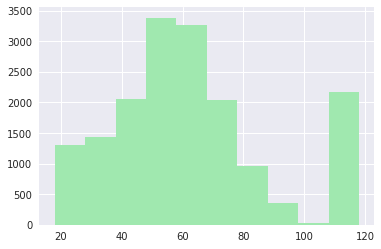

In [16]:
profile.age.hist(color='#A0E8AF', lw=0,bins=10);

- Dropping the rows with age's value 118.

In [17]:
age_to_drop = profile[profile['age'] == 118].index
profile.drop(age_to_drop, inplace=True)

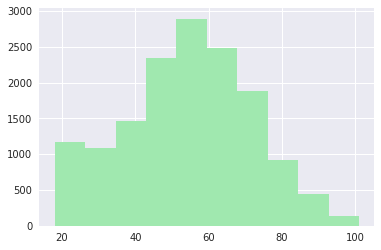

In [18]:
profile.age.hist(color='#A0E8AF', lw=0,bins=10);

- Check if the null values have been dropped:

In [19]:
profile.isna().sum()

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

In [20]:
profile[profile.age > 90][['gender','age','income']].head(10)

,gender,age,income
33,F,96,89000.0
283,F,100,63000.0
530,M,94,50000.0
634,F,95,64000.0
686,F,93,48000.0
751,F,94,84000.0
933,F,91,37000.0
949,M,92,113000.0
977,F,96,72000.0
1083,M,98,52000.0


- The following graphs show the distribution of the age by gender

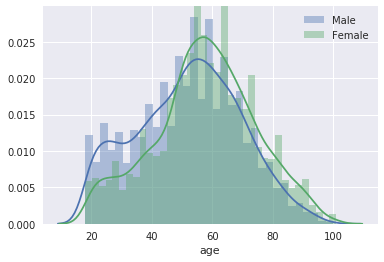

In [21]:
sns.distplot(profile[profile.gender=='M'].age,label='Male')
sns.distplot(profile[profile.gender=='F'].age,label='Female')
plt.legend()
plt.show()

- Sort profile data by age.
- The oldest custumers are women.

In [22]:
sort_age = profile.sort_values(by=['age'],ascending=False)
sort_age.head(10)

,age,became_member_on,gender,id,income
4100,101,20150526,F,d2fdc2be8ab64e4ba04830d441e53fd5,99000.0
1556,101,20171004,F,4d2ccfcbbebf4bd9baf4b7e433d0e288,43000.0
15800,101,20170309,F,047ad0135cfe4c0ea5ba019da4de9c52,59000.0
14846,101,20171109,F,e0ea90ddd2f147e082d21e97f51ec1b1,56000.0
16864,101,20171127,F,1593d617fac246ef8e50dbb0ffd77f5f,82000.0
10939,100,20160629,O,9eb812054d564bdba180dc365f186e23,83000.0
4277,100,20150911,M,b12e8e0f14ae4ad0b576f7c016e7e89b,98000.0
283,100,20150828,F,24c1287eb7a84cfd80472a82e05b1d57,63000.0
1171,100,20170905,F,28bbebb2b76f4057b1115dd80441e37a,118000.0
1612,100,20180123,F,857fc6e18cf74f7b8ebce26bbfbd3028,109000.0


- As shown below 6 of the highest paid people in the data are female.

In [23]:
sort_income = profile.sort_values(by=['income'],ascending=False)
sort_income.head(10)

,age,became_member_on,gender,id,income
306,68,20171025,F,c4a3c86c7b5541cf83d443c2a89e5b5a,120000.0
11502,90,20180512,M,0a947767586e4587b06b8ca3efc3c8e7,120000.0
9404,62,20170802,F,49589dc19aec449f813a3486fc004af3,120000.0
16202,63,20170703,M,3e9d8e91ee7d4669b4ceaed416819c2b,120000.0
2984,88,20171119,F,731b3f8dd6e2404cb9d7dd508e4c43f1,120000.0
5341,62,20170130,F,83050d3e8f1841469a596565018383f1,120000.0
15450,66,20160403,M,5a56cfe9903e420d965a451e84f2bf69,120000.0
12889,65,20171029,F,0580b842b328497ea4bd463af56c17e2,120000.0
7467,54,20171022,M,7d838fbaa68e4c37a5a30fa1691c71c7,120000.0
2924,84,20160213,F,b624317c94fc496288b746f9be43d170,120000.0


In [24]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
age                 14825 non-null int64
became_member_on    14825 non-null int64
gender              14825 non-null object
id                  14825 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


- Now the dataset looks better with less NaN values!

In [25]:
profile.head(5)

,age,became_member_on,gender,id,income
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


## C. Transcript dataset

In [26]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


- We can see that there are no missing values in the transcript dataset

In [27]:
print("\nCheck for missing values:\n")
for data in [transcript]:

    print(data.shape)
    print(data.isnull().sum())
    print("\n")


Check for missing values:

(306534, 4)
event     0
person    0
time      0
value     0
dtype: int64




- We will Focus on the 'offer completed' event

In [54]:
transcript.groupby('event').value.count()

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: value, dtype: int64

In [64]:
# find different keys in value column
keys_list = []
for i in range (len(transcript)):
    for k in transcript['value'][i].keys():
        keys_list.append(k)

keys = np.array(keys_list)
keys = np.unique(keys)
keys

array(['amount', 'offer id', 'offer_id', 'reward'], 
      dtype='<U8')

- I edited the 'value' column into three columns to be able to use them in the data.
- from dictionary to plain values.

In [71]:
# transcript['value'].apply(pd.Series)
transcript = pd.concat([transcript.drop(['value'], axis=1), transcript['value'].apply(pd.Series)], axis=1)
transcript.head()

,event,person,time,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [72]:
transcript['offer id'] = transcript['offer id'].fillna('')
transcript['offer_id'] = transcript['offer_id'].fillna('')
transcript['offerid'] = transcript['offer_id']+transcript['offer id']
transcript.head()

,event,person,time,offer id,amount,offer_id,reward,offerid
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [73]:
transcript = transcript.drop(columns='offer_id')
transcript = transcript.drop(columns='offer id')
transcript.head()

,event,person,time,amount,reward,offerid
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


- We will rename the offerid columns to offer_id

In [75]:
transcript.rename(columns={'offerid':'offer_id'},inplace=True)

In [76]:
transcript.head()

,event,person,time,amount,reward,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [77]:
transcript.groupby('offer_id').event.count()

offer_id
                                    138953
0b1e1539f2cc45b7b9fa7c272da2e1d7     13751
2298d6c36e964ae4a3e7e9706d1fb8c2     20139
2906b810c7d4411798c6938adc9daaa5     15767
3f207df678b143eea3cee63160fa8bed     11761
4d5c57ea9a6940dd891ad53e9dbe8da0     18222
5a8bc65990b245e5a138643cd4eb9837     14305
9b98b8c7a33c4b65b9aebfe6a799e6d9     16202
ae264e3637204a6fb9bb56bc8210ddfd     18062
f19421c1d4aa40978ebb69ca19b0e20d     19131
fafdcd668e3743c1bb461111dcafc2a4     20241
Name: event, dtype: int64

In [78]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [79]:
transcript.groupby('event').offer_id.count()

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: offer_id, dtype: int64

# Data Preparing

- We will merge the three dataset togather.

In [80]:
transcript_2 = transcript.copy()

In [81]:
transcript_2['event'] = transcript_2['event'].str.replace(' ', '-')

In [82]:
transcript_2.head()

,event,person,time,amount,reward,offer_id
0,offer-received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer-received,a03223e636434f42ac4c3df47e8bac43,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer-received,e2127556f4f64592b11af22de27a7932,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer-received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer-received,68617ca6246f4fbc85e91a2a49552598,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


- To deal with the data in an easier way, I will use one-hot encoding for the event column.

In [83]:
dummy = pd.get_dummies(transcript_2['event'])

In [84]:
transcript_2 = pd.concat([transcript_2, dummy], axis=1 )
transcript_2.head()

,event,person,time,amount,reward,offer_id,offer-completed,offer-received,offer-viewed,transaction
0,offer-received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0
1,offer-received,a03223e636434f42ac4c3df47e8bac43,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0
2,offer-received,e2127556f4f64592b11af22de27a7932,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,0,1,0,0
3,offer-received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,0
4,offer-received,68617ca6246f4fbc85e91a2a49552598,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0,0


- Merging transcript dataset with profile dataset.

In [85]:
df_profile = profile.copy()
df_profile.head(2)

,age,became_member_on,gender,id,income
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0


In [86]:
df_profile.rename(columns={'id':'person'},inplace=True)

In [87]:
df_transcript_profile = pd.merge(transcript_2, df_profile, on='person')
df_transcript_profile.head()

,event,person,time,amount,reward,offer_id,offer-completed,offer-received,offer-viewed,transaction,age,became_member_on,gender,income
0,offer-received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,75,20170509,F,100000.0
1,offer-viewed,78afa995795e4d85b5d9ceeca43f5fef,6,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,1,0,75,20170509,F,100000.0
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,19.89,NaN,,0,0,0,1,75,20170509,F,100000.0
3,offer-completed,78afa995795e4d85b5d9ceeca43f5fef,132,NaN,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,75,20170509,F,100000.0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,17.78,NaN,,0,0,0,1,75,20170509,F,100000.0


- Change the name if id column to offer_id to merge them on the same name.

In [88]:
df_portfolio = portfolio.copy()
df_portfolio.rename(columns={'id':'offer_id'},inplace=True)
df_portfolio.head(2)

,difficulty,duration,offer_id,offer_type,reward,mobile,social,email,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1


- Merging the new dataset (df_transcript_profile) with portfolio dataset.

In [89]:
df_transcript_profile_portfolio = pd.merge(df_transcript_profile, df_portfolio, on='offer_id', how='left')
df_transcript_profile_portfolio.head()

,event,person,time,amount,reward_x,offer_id,offer-completed,offer-received,offer-viewed,transaction,...,gender,income,difficulty,duration,offer_type,reward_y,mobile,social,email,web
0,offer-received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,...,F,100000.0,5.0,7.0,bogo,5.0,1.0,0.0,1.0,1.0
1,offer-viewed,78afa995795e4d85b5d9ceeca43f5fef,6,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,1,0,...,F,100000.0,5.0,7.0,bogo,5.0,1.0,0.0,1.0,1.0
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,19.89,NaN,,0,0,0,1,...,F,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,offer-completed,78afa995795e4d85b5d9ceeca43f5fef,132,NaN,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,...,F,100000.0,5.0,7.0,bogo,5.0,1.0,0.0,1.0,1.0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,17.78,NaN,,0,0,0,1,...,F,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Processing and Exploring

Analyzing Data

1. What is the most compleated offer?

2. What is the median income for Starbucks customers? (Median incomes are used as measures because they tend to more accurately represent what people make in a given area)

3. What is the age segments for Starbucks customers?

4. The loyality of the customers?

5. What is the correlation between the attributes?

6. Have a better visualization for the data.

### Completed offers

- Fix "the became_member_on" column to the right date format.

In [90]:
df_transcript_profile_portfolio['became_member_on'].head()

0    20170509
1    20170509
2    20170509
3    20170509
4    20170509
Name: became_member_on, dtype: int64

In [91]:
df_transcript_profile_portfolio['became_member_on'] = pd.to_datetime(df_transcript_profile_portfolio['became_member_on'], format='%Y%m%d')
df_transcript_profile_portfolio['became_member_on'].head()

0   2017-05-09
1   2017-05-09
2   2017-05-09
3   2017-05-09
4   2017-05-09
Name: became_member_on, dtype: datetime64[ns]

- To check the compleated offers for each type.

In [92]:
df_transcript_profile_portfolio.groupby(["event", "offer_type"]).size()

event            offer_type   
offer-completed  bogo             15258
                 discount         17186
offer-received   bogo             26537
                 discount         26664
                 informational    13300
offer-viewed     bogo             22039
                 discount         18461
                 informational     9360
dtype: int64

- I will give each offer ID a number so I can use it in the data acalyzing and machine learning easily.

In [93]:
offer_id = df_transcript_profile_portfolio['offer_id'].unique()
offer_id

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9', '',
       '5a8bc65990b245e5a138643cd4eb9837',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '2906b810c7d4411798c6938adc9daaa5',
       '3f207df678b143eea3cee63160fa8bed',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '4d5c57ea9a6940dd891ad53e9dbe8da0'], dtype=object)

In [94]:
offer_dict = pd.Series(offer_id).to_dict()
offer_dict

{0: '9b98b8c7a33c4b65b9aebfe6a799e6d9',
 1: '',
 2: '5a8bc65990b245e5a138643cd4eb9837',
 3: 'ae264e3637204a6fb9bb56bc8210ddfd',
 4: 'f19421c1d4aa40978ebb69ca19b0e20d',
 5: '2906b810c7d4411798c6938adc9daaa5',
 6: '3f207df678b143eea3cee63160fa8bed',
 7: 'fafdcd668e3743c1bb461111dcafc2a4',
 8: '2298d6c36e964ae4a3e7e9706d1fb8c2',
 9: '0b1e1539f2cc45b7b9fa7c272da2e1d7',
 10: '4d5c57ea9a6940dd891ad53e9dbe8da0'}

In [95]:
offer_dict = dict([(value, key) for key, value in offer_dict.items()]) 
offer_dict

{'9b98b8c7a33c4b65b9aebfe6a799e6d9': 0,
 '': 1,
 '5a8bc65990b245e5a138643cd4eb9837': 2,
 'ae264e3637204a6fb9bb56bc8210ddfd': 3,
 'f19421c1d4aa40978ebb69ca19b0e20d': 4,
 '2906b810c7d4411798c6938adc9daaa5': 5,
 '3f207df678b143eea3cee63160fa8bed': 6,
 'fafdcd668e3743c1bb461111dcafc2a4': 7,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 8,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 9,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 10}

In [96]:
df_transcript_profile_portfolio['offer_id'] = df_transcript_profile_portfolio['offer_id'].map(offer_dict)
df_transcript_profile_portfolio.head()

,event,person,time,amount,reward_x,offer_id,offer-completed,offer-received,offer-viewed,transaction,...,gender,income,difficulty,duration,offer_type,reward_y,mobile,social,email,web
0,offer-received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,0,0,1,0,0,...,F,100000.0,5.0,7.0,bogo,5.0,1.0,0.0,1.0,1.0
1,offer-viewed,78afa995795e4d85b5d9ceeca43f5fef,6,NaN,NaN,0,0,0,1,0,...,F,100000.0,5.0,7.0,bogo,5.0,1.0,0.0,1.0,1.0
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,19.89,NaN,1,0,0,0,1,...,F,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,offer-completed,78afa995795e4d85b5d9ceeca43f5fef,132,NaN,5.0,0,1,0,0,0,...,F,100000.0,5.0,7.0,bogo,5.0,1.0,0.0,1.0,1.0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,17.78,NaN,1,0,0,0,1,...,F,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- To avoid the nan values in the data.

In [97]:
df_transcript_profile_portfolio['offer_id'] = df_transcript_profile_portfolio['offer_id'].replace(1, np.nan)
df_transcript_profile_portfolio.head()

,event,person,time,amount,reward_x,offer_id,offer-completed,offer-received,offer-viewed,transaction,...,gender,income,difficulty,duration,offer_type,reward_y,mobile,social,email,web
0,offer-received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,0.0,0,1,0,0,...,F,100000.0,5.0,7.0,bogo,5.0,1.0,0.0,1.0,1.0
1,offer-viewed,78afa995795e4d85b5d9ceeca43f5fef,6,NaN,NaN,0.0,0,0,1,0,...,F,100000.0,5.0,7.0,bogo,5.0,1.0,0.0,1.0,1.0
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,19.89,NaN,NaN,0,0,0,1,...,F,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,offer-completed,78afa995795e4d85b5d9ceeca43f5fef,132,NaN,5.0,0.0,1,0,0,0,...,F,100000.0,5.0,7.0,bogo,5.0,1.0,0.0,1.0,1.0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,17.78,NaN,NaN,0,0,0,1,...,F,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
df_transcript_profile_portfolio['offer_id'].unique()

array([  0.,  nan,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])

In [99]:
df_transcript_profile_portfolio.groupby(["event", "offer_type"]).size()

event            offer_type   
offer-completed  bogo             15258
                 discount         17186
offer-received   bogo             26537
                 discount         26664
                 informational    13300
offer-viewed     bogo             22039
                 discount         18461
                 informational     9360
dtype: int64

In [100]:
# transcript_nd = transcript.fillna('')
# # transcript_nd = transcript.astype(int)
# transcript_nd.head()

- the highest completed offer is 7 which is: fafdcd668e3743c1bb461111dcafc2a4

In [101]:
df_transcript_profile_portfolio.groupby('offer_id').event.count()

offer_id
0.0     14372
2.0     12516
3.0     16241
4.0     16989
5.0     14002
6.0     10144
7.0     18062
8.0     17920
9.0     12327
10.0    16232
Name: event, dtype: int64

- From the graph below, we can see the most and least compleated offer sorted.

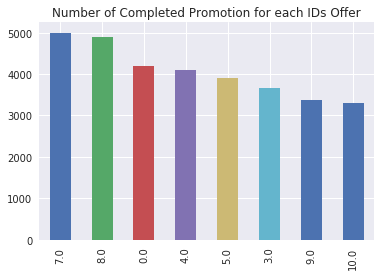

In [102]:
completed_offer = df_transcript_profile_portfolio[df_transcript_profile_portfolio
                                                  ['event'] == 'offer-completed']
completed_offer['offer_id'].value_counts()

# completed_offer.head()
completed_offer['offer_id'].value_counts().plot(kind='bar')

plt.title('Number of Completed Promotion for each IDs Offer')

plt.xticks(rotation = 90)
plt.show();

We have:
1. 32444 offer-completed    
2. 66501 offer-received     
3. 49860 offer-viewed       

In [103]:
df_transcript_profile_portfolio.groupby('event').offer_id.count()

event
offer-completed    32444
offer-received     66501
offer-viewed       49860
transaction            0
Name: offer_id, dtype: int64

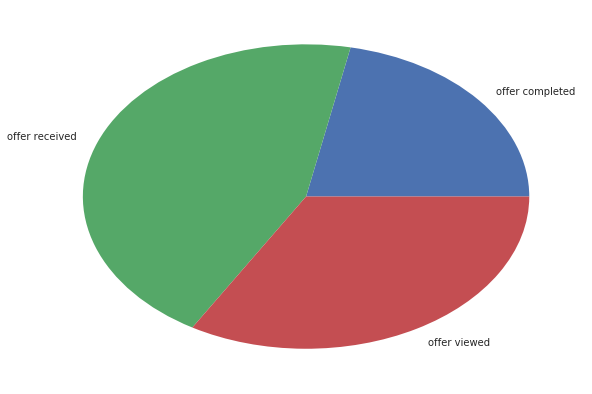

In [104]:
data = [df_transcript_profile_portfolio.groupby('event').offer_id.count()[0], df_transcript_profile_portfolio.groupby('event').offer_id.count()[1],df_transcript_profile_portfolio.groupby('event').offer_id.count()[2]]
offers = ['offer completed', 'offer received', 'offer viewed ']

fig = plt.figure(figsize =(10, 7))
plt.pie(data, labels = offers)
plt.show()

- The number of completed offers based on the offer type:

In [105]:
df_transcript_profile_portfolio.groupby(["event", "offer_type"]).size()

event            offer_type   
offer-completed  bogo             15258
                 discount         17186
offer-received   bogo             26537
                 discount         26664
                 informational    13300
offer-viewed     bogo             22039
                 discount         18461
                 informational     9360
dtype: int64

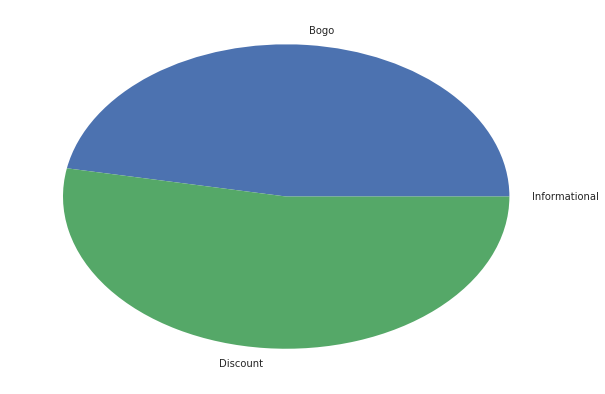

In [106]:
data = [df_transcript_profile_portfolio.groupby(["event", "offer_type"]).size()[0], df_transcript_profile_portfolio.groupby(["event", "offer_type"]).size()[1],0]
offers = ['Bogo', 'Discount', 'Informational']

fig = plt.figure(figsize =(10, 7))
plt.pie(data, labels = offers)
plt.show()

### Starbucks customers data
1. income details
2. age details
3. gender details
4. loyality

- the median of the income of the starbucks customers:

In [107]:
df_transcript_profile_portfolio['income'].median()

62000.0

- the average age for starbucks customers:

In [108]:
df_transcript_profile_portfolio['age'].mean()

53.840696284673086

- From the avarage of the age, we can observe that the most customers might be adults (if we have normal distribution)

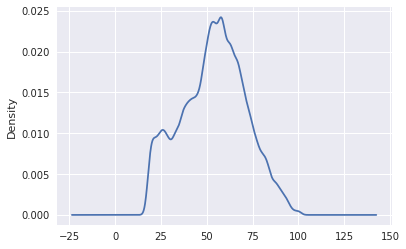

In [109]:
df_transcript_profile_portfolio['age'].plot(kind='kde')
plt.show()

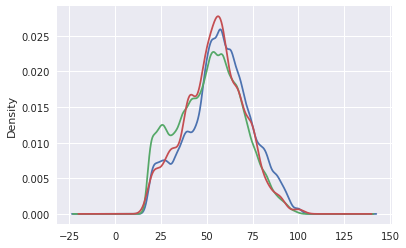

In [110]:
df_transcript_profile_portfolio.groupby('gender').age.plot(kind='kde')
plt.show()

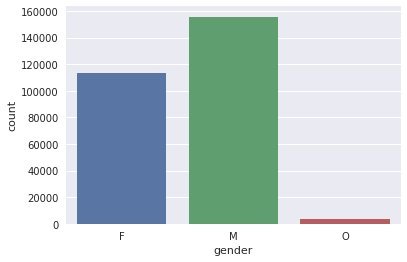

In [111]:
sns.countplot(df_transcript_profile_portfolio['gender'])
plt.show()

- Most of the customers are males and adults.

In [112]:
df_transcript_profile_portfolio.groupby(["gender"]).size()

gender
F    113101
M    155690
O      3971
dtype: int64

- To have a better view on the age of the customers, I will categorize then into age gropus:

In [113]:
df_transcript_profile_portfolio['age_groups'] = pd.cut(df_transcript_profile_portfolio.age, bins=[9,20, 29, 39, 49, 59, 69, 79, 89, 99], 
                               labels=['less than 20','20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s'])

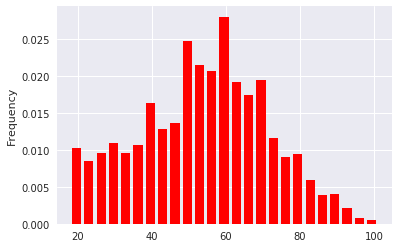

In [114]:
df_transcript_profile_portfolio['age'].plot.hist(bins=25, density=True, color='red', rwidth=0.75)

In [115]:
df_transcript_profile_portfolio.groupby(["gender","age_groups"]).size()

gender  age_groups  
F       less than 20     1652
        20s              7647
        30s             10231
        40s             15635
        50s             28060
        60s             24112
        70s             14548
        80s              8243
        90s              2704
M       less than 20     4815
        20s             16517
        30s             19563
        40s             26078
        50s             34689
        60s             29034
        70s             16489
        80s              6748
        90s              1713
O       less than 20       77
        20s               233
        30s               436
        40s               767
        50s              1018
        60s               780
        70s               453
        80s               156
        90s                32
dtype: int64

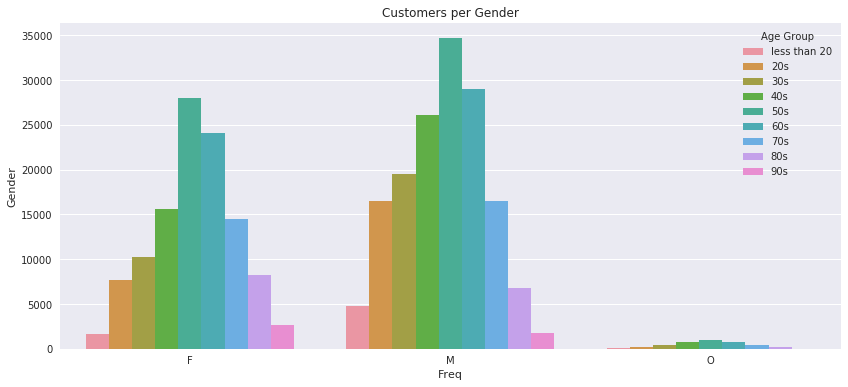

In [116]:
plt.figure(figsize=(14, 6))
sns.countplot(x="gender", hue="age_groups", data=df_transcript_profile_portfolio)
plt.title('Customers per Gender')
plt.ylabel('Gender')
plt.xlabel('Freq')
plt.xticks(rotation = 0)
plt.legend(title='Age Group')
plt.show();

In [117]:
# x1 = 0
# x2 = 0
# x3 = 0
# x4 = 0

# for i in range(len(transcript)):
#     if transcript.iloc(0)[i][6] == bogo_offer['id'][0]:
#         x1=x1+1
# print(x1)

# for i in range(len(transcript)):
#     if transcript.iloc(0)[i][6] == bogo_offer['id'][1]:
#         x2=x2+1
# print(x2)

# for i in range(len(transcript)):
#     if transcript.iloc(0)[i][6] == bogo_offer['id'][3]:
#         x3=x3+1
# print(x3)

# for i in range(len(transcript)):
#     if transcript.iloc(0)[i][6] == bogo_offer['id'][8]:
#         x4=x4+1
# print(x4)

# completed_bogo_offer = x1+x2+x3+x4

# print(completed_bogo_offer)


In [118]:
# x1 = 0
# x2 = 0
# x3 = 0
# x4 = 0

# for i in range(len(transcript)):
#     if transcript.iloc(0)[i][6] == discount_offer['id'][4]:
#         x1=x1+1
# print(x1)

# for i in range(len(transcript)):
#     if transcript.iloc(0)[i][6] == discount_offer['id'][5]:
#         x2=x2+1
# print(x2)

# for i in range(len(transcript)):
#     if transcript.iloc(0)[i][6] == discount_offer['id'][6]:
#         x3=x3+1
# print(x3)

# for i in range(len(transcript)):
#     if transcript.iloc(0)[i][6] == discount_offer['id'][9]:
#         x4=x4+1
# print(x4)

# completed_discount_offer = x1+x2+x3+x4

# print(completed_discount_offer)


In [119]:
# x1 = 0
# x2 = 0


# for i in range(len(transcript)):
#     if transcript.iloc(0)[i][3] == informational_offer['id'][2]:
#         x1=x1+1
# print(x1)

# for i in range(len(transcript)):
#     if transcript.iloc(0)[i][3] == informational_offer['id'][7]:
#         x2=x2+1
# print(x2)

# completed_informational_offer = x1+x2

# print(completed_informational_offer)


- Seems people between 51 and 63 are the most common customers.

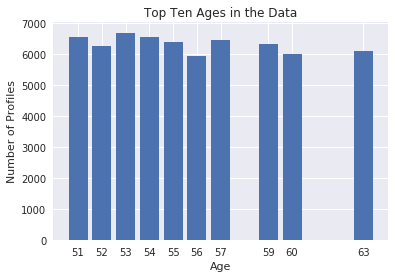

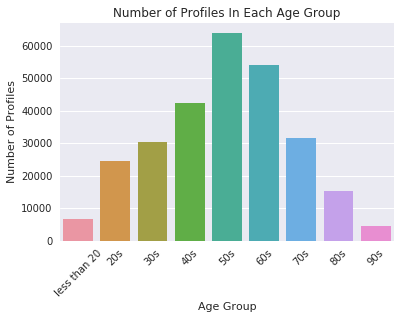

In [78]:
top10_ages = df_transcript_profile_portfolio['age'].value_counts()[1:].head(10).reset_index()
plt.bar(top10_ages['index'], top10_ages['age'])
plt.title('Top Ten Ages in the Data')
plt.ylabel('Number of Profiles')
plt.xlabel('Age')
plt.xticks(top10_ages['index'], rotation = 0)
plt.show();

sns.countplot(x='age_groups', data=df_transcript_profile_portfolio)
plt.title('Number of Profiles In Each Age Group')
plt.ylabel('Number of Profiles')
plt.xlabel('Age Group')
plt.xticks(rotation = 45)
plt.show();




- Most popular offer type per age.
- Seems bogo and discount are the most.

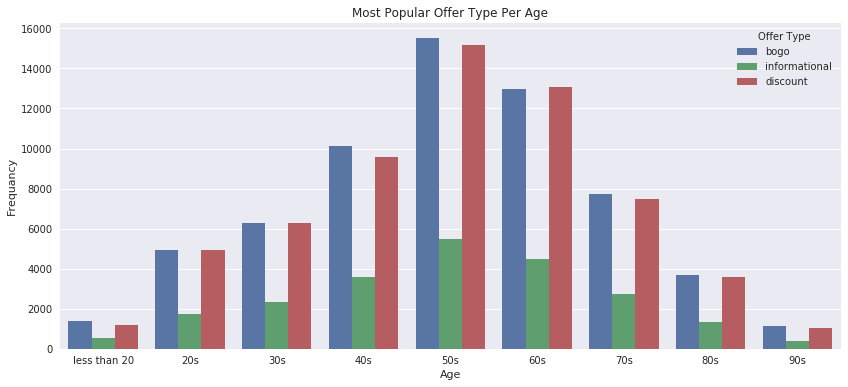

In [79]:
plt.figure(figsize=(14, 6))
sns.countplot(x="age_groups", hue="offer_type", data=df_transcript_profile_portfolio)
plt.title('Most Popular Offer Type Per Age')
plt.ylabel('Frequancy')
plt.xlabel('Age')
plt.xticks(rotation = 0)
plt.legend(title='Offer Type')
plt.show();

- The most loyal customers (the one who spent the most)
- 8 of the most top 10 loyal customers are males
- The average pay for the top ten customers is 86400.0 and they spend 1312.9 in average.

In [80]:
new_profile_transcript_spent_amount = df_transcript_profile_portfolio.groupby(["person","gender","age_groups","income"]).amount.sum().reset_index()
most_loyal_customers = new_profile_transcript_spent_amount.sort_values(by='amount',ascending=False)
#top 10 customers
most_loyal_customers.head(10).describe()

,income,amount
count,10.000000,10.000000
mean,86400.000000,1312.900000
std,14683.323874,113.662708
min,64000.000000,1206.000000
25%,79000.000000,1247.000000
50%,83000.000000,1299.500000
75%,96250.000000,1318.500000
max,111000.000000,1606.000000


In [81]:
most_loyal_customers.head(10)

,person,gender,age_groups,income,amount
3503,3c8d541112a74af99e88abbd0692f00e,M,70s,97000.0,1606
13997,f1d65ae63f174b8f80fa063adcaa63b7,M,30s,64000.0,1360
10191,ae6f43089b674728a50b8727252d3305,F,30s,71000.0,1320
6684,73afdeca19e349b98f09e928644610f8,M,50s,86000.0,1314
5686,626df8678e2a4953b9098246418c9cfa,M,50s,103000.0,1314
4799,52959f19113e4241a8cb3bef486c6412,M,50s,111000.0,1285
10110,ad1f0a409ae642bc9a43f31f56c130fc,M,60s,80000.0,1256
12185,d240308de0ee4cf8bb6072816268582b,F,40s,94000.0,1244
8625,946fc0d3ecc4492aa4cc06cf6b1492c3,M,50s,79000.0,1224
5792,6406abad8e2c4b8584e4f68003de148d,M,60s,79000.0,1206


In [82]:
df_transcript_profile_portfolio.groupby(["gender"]).size()

gender
F    113101
M    155690
O      3971
dtype: int64

- Based on previous information, we found that the number of male customers are the most. but in the next cell I found that females spent more money on the offers.

In [83]:
gender_spending_amount = df_transcript_profile_portfolio.groupby(["gender"]).amount.sum().reset_index()
gender_spending_amount

,gender,amount
0,F,839287
1,M,809160
2,O,25506


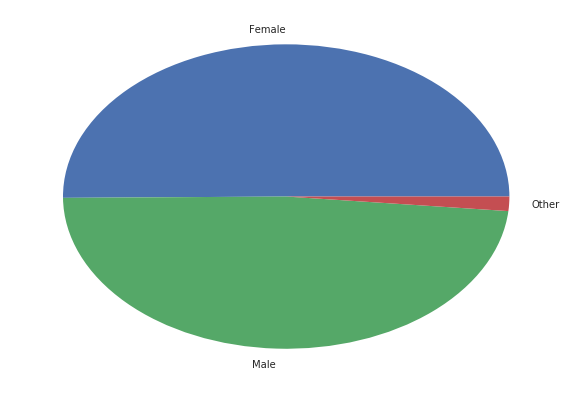

In [84]:
data = [gender_spending_amount.iloc(0)[0][1], gender_spending_amount.iloc(0)[1][1], gender_spending_amount.iloc(0)[2][1]]
offers = ['Female', 'Male', 'Other']

fig = plt.figure(figsize =(10, 7))
plt.pie(data, labels = offers)
plt.show()

- Despite the fact that males are getting paid more than the females.

In [85]:
gender_income = df_transcript_profile_portfolio.groupby(["gender"]).income.sum().reset_index()
gender_income

,gender,income
0,F,7.865807e+09
1,M,9.433115e+09
2,O,2.497670e+08


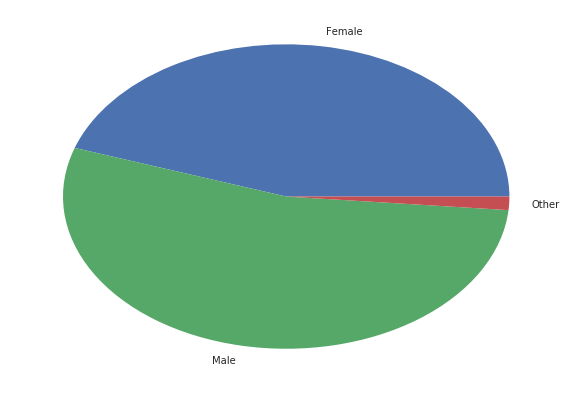

In [86]:
data = [gender_income.iloc(0)[0][1], gender_income.iloc(0)[1][1], gender_income.iloc(0)[2][1]]
offers = ['Female', 'Male', 'Other']

fig = plt.figure(figsize =(10, 7))
plt.pie(data, labels = offers)
plt.show()

- People in 50s are the ones who spend the most.

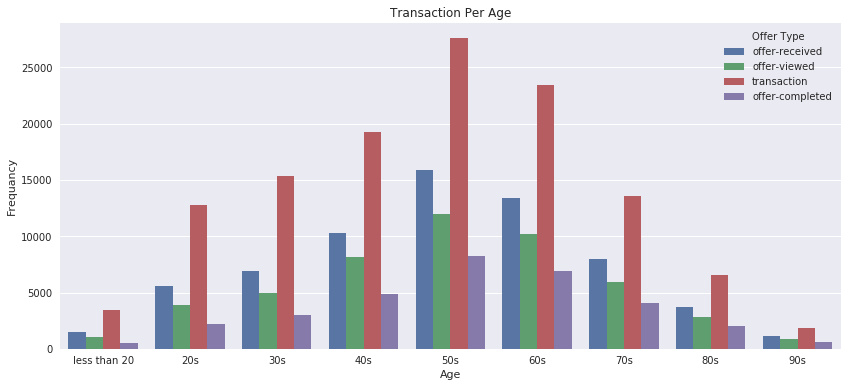

In [87]:
plt.figure(figsize=(14, 6))
sns.countplot(x="age_groups", hue="event", data=df_transcript_profile_portfolio)
plt.title('Transaction Per Age')
plt.ylabel('Frequancy')
plt.xlabel('Age')
plt.xticks(rotation = 0)
plt.legend(title='Offer Type')
plt.show();



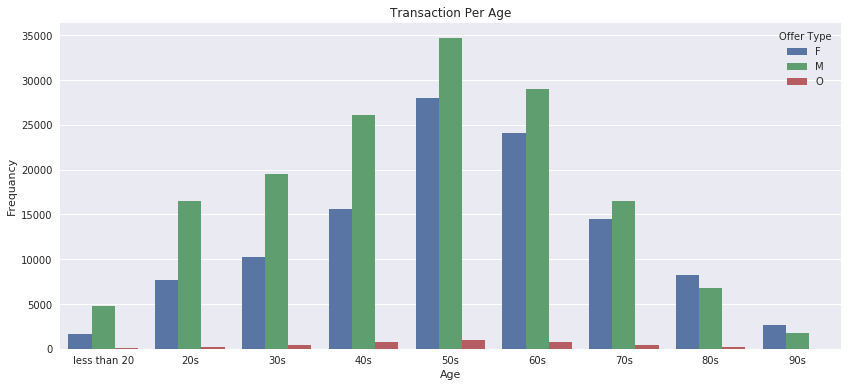

In [88]:
plt.figure(figsize=(14, 6))
sns.countplot(x="age_groups", hue="gender", data=df_transcript_profile_portfolio)
plt.title('Transaction Per Age')
plt.ylabel('Frequancy')
plt.xlabel('Age')
plt.xticks(rotation = 0)
plt.legend(title='Offer Type')
plt.show();

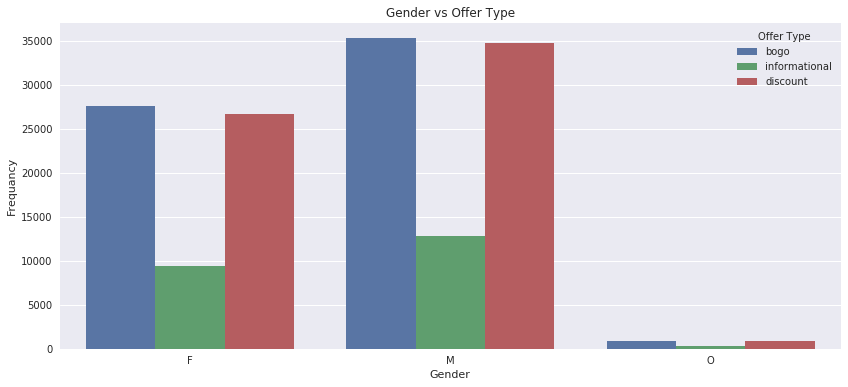

In [89]:
plt.figure(figsize=(14, 6))
sns.countplot(x="gender", hue='offer_type', data=df_transcript_profile_portfolio)
plt.title('Gender vs Offer Type')
plt.ylabel('Frequancy')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.legend(title='Offer Type')
plt.show();


# Machine Learning

- In this part, I will build a model that predicts if a customer will respond an offer or not.

In [90]:
df_ml = df_transcript_profile_portfolio.copy()
df_ml.head(2)

,event,person,time,offer_id,amount,reward_x,offer-completed,offer-received,offer-viewed,transaction,...,income,difficulty,duration,offer_type,reward_y,social,mobile,email,web,age_groups
0,offer-received,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,0,0,0,1,0,0,...,100000.0,5.0,7.0,bogo,5.0,0.0,1.0,1.0,1.0,70s
1,offer-viewed,78afa995795e4d85b5d9ceeca43f5fef,6,0.0,0,0,0,0,1,0,...,100000.0,5.0,7.0,bogo,5.0,0.0,1.0,1.0,1.0,70s


In [91]:
df_ml2 = df_ml.copy()
df_ml2.head(2)

,event,person,time,offer_id,amount,reward_x,offer-completed,offer-received,offer-viewed,transaction,...,income,difficulty,duration,offer_type,reward_y,social,mobile,email,web,age_groups
0,offer-received,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,0,0,0,1,0,0,...,100000.0,5.0,7.0,bogo,5.0,0.0,1.0,1.0,1.0,70s
1,offer-viewed,78afa995795e4d85b5d9ceeca43f5fef,6,0.0,0,0,0,0,1,0,...,100000.0,5.0,7.0,bogo,5.0,0.0,1.0,1.0,1.0,70s


- we will split the dataset into features and target

In [92]:
df_ml['event'].unique()

array(['offer-received', 'offer-viewed', 'transaction', 'offer-completed'], dtype=object)

In [93]:
df_ml['offer_id'].unique()

array([  0.,  nan,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])

In [94]:
df_ml['age_groups'].unique()

[70s, 60s, 50s, 80s, 40s, 20s, 90s, less than 20, 30s, NaN]
Categories (9, object): [less than 20 < 20s < 30s < 40s ... 60s < 70s < 80s < 90s]

In [95]:
df_ml['gender'].unique()

array(['F', 'M', 'O'], dtype=object)

- The features:
reference: https://www.datacamp.com/community/tutorials/categorical-data


In [96]:
labels_event = df_ml['event'].astype('category').cat.categories.tolist()
replace_map_comp_event = {'event' : {k: v for k,v in zip(labels_event,list(range(1,len(labels_event)+1)))}}
print(replace_map_comp_event)

labels_offer_id = df_ml['offer_id'].astype('category').cat.categories.tolist()
replace_map_comp_offer_id = {'offer_id' : {k: v for k,v in zip(labels_offer_id,list(range(1,len(labels_offer_id)+1)))}}
print(replace_map_comp_offer_id)

labels_age_group = df_ml['age_groups'].astype('category').cat.categories.tolist()
replace_map_comp_age_group = {'age_groups' : {k: v for k,v in zip(labels_age_group,list(range(1,len(labels_age_group)+1)))}}
print(replace_map_comp_age_group)

labels_gender = df_ml['gender'].astype('category').cat.categories.tolist()
replace_map_comp_gender = {'gender' : {k: v for k,v in zip(labels_gender,list(range(1,len(labels_gender)+1)))}}
print(replace_map_comp_gender)

{'event': {'offer-completed': 1, 'offer-received': 2, 'offer-viewed': 3, 'transaction': 4}}
{'offer_id': {0.0: 1, 2.0: 2, 3.0: 3, 4.0: 4, 5.0: 5, 6.0: 6, 7.0: 7, 8.0: 8, 9.0: 9, 10.0: 10}}
{'age_groups': {'less than 20': 1, '20s': 2, '30s': 3, '40s': 4, '50s': 5, '60s': 6, '70s': 7, '80s': 8, '90s': 9}}
{'gender': {'F': 1, 'M': 2, 'O': 3}}


- The Target:

In [97]:
labels_offer_type = df_ml['offer_type'].astype('category').cat.categories.tolist()
replace_map_comp_offer_type = {'offer_type' : {k: v for k,v in zip(labels_offer_type,list(range(1,len(labels_offer_type)+1)))}}
print(replace_map_comp_offer_type)

{'offer_type': {'bogo': 1, 'discount': 2, 'informational': 3}}


- prepare a new data with the features and the targets (replace categorical with numerical):

In [98]:
df_ml = df_ml.dropna()

In [99]:
df_ml = df_ml.loc[:, df_ml.columns.intersection(['event','person','time','offer_id', 'amount', 'reward', 'offer_type', 'age_groups', 'gender','income'])]
df_ml.head()

,event,person,time,offer_id,amount,gender,income,offer_type,age_groups
0,offer-received,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,0,F,100000.0,bogo,70s
1,offer-viewed,78afa995795e4d85b5d9ceeca43f5fef,6,0.0,0,F,100000.0,bogo,70s
3,offer-completed,78afa995795e4d85b5d9ceeca43f5fef,132,0.0,0,F,100000.0,bogo,70s
5,offer-received,78afa995795e4d85b5d9ceeca43f5fef,168,2.0,0,F,100000.0,informational,70s
6,offer-viewed,78afa995795e4d85b5d9ceeca43f5fef,216,2.0,0,F,100000.0,informational,70s


In [100]:
df_ml.replace(replace_map_comp_event, inplace=True)
df_ml.replace(replace_map_comp_age_group, inplace=True)
df_ml.replace(replace_map_comp_gender, inplace=True)
df_ml.replace(replace_map_comp_offer_type, inplace=True)

In [101]:
df_ml.head()

,event,person,time,offer_id,amount,gender,income,offer_type,age_groups
0,2,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,0,1,100000.0,1,7
1,3,78afa995795e4d85b5d9ceeca43f5fef,6,0.0,0,1,100000.0,1,7
3,1,78afa995795e4d85b5d9ceeca43f5fef,132,0.0,0,1,100000.0,1,7
5,2,78afa995795e4d85b5d9ceeca43f5fef,168,2.0,0,1,100000.0,3,7
6,3,78afa995795e4d85b5d9ceeca43f5fef,216,2.0,0,1,100000.0,3,7


- Split the data into features and target label

In [102]:
target = df_ml['offer_type']
features = df_ml.drop(['person', 'offer_type'], axis = 1)

In [103]:
target.head()


0    1
1    1
3    1
5    3
6    3
Name: offer_type, dtype: int64

In [104]:
features.head()


,event,time,offer_id,amount,gender,income,age_groups
0,2,0,0.0,0,1,100000.0,7
1,3,6,0.0,0,1,100000.0,7
3,1,132,0.0,0,1,100000.0,7
5,2,168,2.0,0,1,100000.0,7
6,3,216,2.0,0,1,100000.0,7


- Split the data into training data and testing data.

ref: https://www.aboutdatablog.com/post/splitting-your-data-to-fit-any-machine-learning-model

In [105]:
from sklearn.model_selection import train_test_split, GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=0)


print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (111471, 7)
Training Labels Shape: (111471,)
Testing Features Shape: (37157, 7)
Testing Labels Shape: (37157,)


## Metrics

Because I have a simple classification problem, I will evaluate my models based on accuracy. I'd like to see how well our model performs by comparing the number of correct predictions to the total number of predictions.

The accuracy of a machine learning model is the metric used to determine which model is best at identifying relationships and patterns between variables in a dataset based on the input, or training, data. The better a model generalizes to 'unseen' data, the better predictions and insights it can generate, delivering more business value.


Accuracy = (TP+TN)/(TP+FP+FN+TN). Not to mention that this is a simple classification problem, so it male senceseto accuracy for the evaluation.

ref:
- https://www.datarobot.com/wiki/accuracy/#:~:text=Machine%20learning%20model%20accuracy%20is,input%2C%20or%20training%2C%20data.

- https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234

In [106]:
from sklearn import metrics

## 1. Decision Tree

In [107]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

pred = dt.predict(X_test)
errors = pred - y_test
abs_errors = abs(errors)
mape = 100 * (abs_errors / y_test)
dt_accuracy = 100 - np.mean(mape)

print("Accuracy of DecisionTree classifier on training set:",dt.score(X_train, y_train)*100.0, "%")
print("Prediction Accuracy:", dt_accuracy, "%")

Accuracy of DecisionTree classifier on training set: 100.0 %
Prediction Accuracy: 100.0 %


## 2. Logistic Regression

In [108]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

pred = logreg.predict(X_test)
errors = pred - y_test
abs_errors = abs(errors)
mape = 100 * (abs_errors / y_test)
logreg_accuracy = 100 - np.mean(mape)

print("Accuracy of LogisticRegression classifier on training set:",logreg.score(X_train, y_train)*100.0, "%")
print("Prediction Accuracy:",logreg_accuracy, "%")

Accuracy of LogisticRegression classifier on training set: 65.9902575558 %
Prediction Accuracy: 76.1538875582 %


## 3. K-Nearest Neighbors

In [109]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

pred = knn.predict(X_test)
knn_accuracy = metrics.accuracy_score(y_test,pred)*100

print("Accuracy of KNeighborsClassifier classifier on training set:",knn.score(X_train, y_train)*100.0, "%")
print("Prediction Accuracy:",knn_accuracy, "%")




Accuracy of KNeighborsClassifier classifier on training set: 85.4051726458 %
Prediction Accuracy: 76.0395080335 %


## 4. Gaussian Naive Bayes

In [110]:
gnb = GaussianNB() 
gnb.fit(X_train, y_train) 

pred = gnb.predict(X_test)
gnb_accuracy = metrics.accuracy_score(y_test,pred)*100

print("Accuracy of GaussianNB classifier on training set:",gnb.score(X_train, y_train)*100.0, "%")
print("Prediction Accuracy:",gnb_accuracy, "%")

Accuracy of GaussianNB classifier on training set: 63.7367566452 %
Prediction Accuracy: 63.8587614716 %


## 5. Random Forest

In [111]:
rf = RandomForestRegressor(n_estimators = 80, random_state = 42)
rf.fit(X_train, y_train)

pred = rf.predict(X_test)
rf_accuracy = metrics.accuracy_score(y_test,pred)*100

print("Accuracy of RandomForestRegressor classifier on training set:",rf.score(X_train, y_train)*100.0, "%")
print("Prediction Accuracy:",rf_accuracy, "%")

Accuracy of RandomForestRegressor classifier on training set: 100.0 %
Prediction Accuracy: 100.0 %


Obtainning the name of the models and the results.

Creating the variables that will be used to fill the results table

In [139]:
# reference: https://stackoverflow.com/a/52768022
models = [dt, logreg, knn, gnb, rf]
model_names = [type(n).__name__ for n in models]
training_accuracy = [x.score(X_train, y_train)*100 for x in models]
predection_accuracy = [dt_accuracy, logreg_accuracy, knn_accuracy, gnb_accuracy, rf_accuracy]

In [140]:
results = [training_accuracy, predection_accuracy]
results_df = pd.DataFrame(results, columns = model_names, index=['Training Accuracy', 'Predicting Accuracy']) 

In [141]:
results_df

,DecisionTreeClassifier,LogisticRegression,KNeighborsClassifier,GaussianNB,RandomForestRegressor
Training Accuracy,100.0,65.990258,85.405173,63.736757,100.0
Predicting Accuracy,100.0,76.153888,76.039508,63.858761,100.0


According to the table above, we achieved 100 percent accuracy Random Forest and Decision Tree models in the training and testing datasets. 

To avoid overfitting, I will use Logistic Regression and KNN. 

- Logistic Regression produced 65.99 percent on training and 76.15 percent on testing. 
- KNN produced 85.40 percent on training and 76.04 percent on testing. 

Because we have few binomial outcomes (BOGO = 1, discount = 2, informational = 3), we should use logistic regression. It's good in this case because we have a lot of data to work with.

In [142]:
# Tuning to get better accuracy
dual = [True, False]
max_iter = [100, 120, 140, 160, 180, 200, 220]
C = [1.0,1.5,2.0,2.5,3.0,3.5,4.0]
param_grid = dict(dual = dual, max_iter = max_iter, C = C)

lr = LogisticRegression(random_state=42)
grid = GridSearchCV(estimator = lr, param_grid = param_grid, cv = 3, n_jobs = -1)
grid_result = grid.fit(X_train, y_train)

print(f'Best Score: {grid_result.best_score_}')
print(f'Best params: {grid_result.best_params_}')

Best Score: 0.6578213167550304
Best params: {'C': 1.0, 'dual': False, 'max_iter': 100}


In [112]:
# Tuning to get better accuracy
dual = [True, False]
max_iter = [70,100]
C = [1.0,1.5,2.0]
param_grid = dict(dual = dual, max_iter = max_iter, C = C)

lr = LogisticRegression(random_state=42)
grid = GridSearchCV(estimator = lr, param_grid = param_grid, cv = 2, n_jobs = -1)
grid_result = grid.fit(X_train, y_train)

print(f'Best Score: {grid_result.best_score_}')
print(f'Best params: {grid_result.best_params_}')

Best Score: 0.6569331933866207
Best params: {'C': 1.0, 'dual': False, 'max_iter': 70}


In [119]:
# Tuning to get better accuracy
k_range = list(range(1,31))
weight_options = ["uniform", "distance"]

param_grid = dict(n_neighbors = k_range, weights = weight_options)
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid, cv = 10, scoring = 'accuracy')
grid_result = grid.fit(X_train, y_train)

In [120]:
print(f'Best Score: {grid_result.best_score_}')
print(f'Best params: {grid_result.best_params_}')

Best Score: 0.7898197737528146
Best params: {'n_neighbors': 4, 'weights': 'distance'}


## Conclusion


In this project, I attempted to analyze and create a model that would predict the best offer to make to a Starbucks customer. 

Before beginning the analysis, I explored the data to see what I needed to change. After cleaning the data, I performed some exploratory analysis on it. 


Finally, because females have more completed offers, the company should make more offers to them. And they should concentrate more on BOGO and discount offers because they are the ones that encourage customers to buy more.